In [1]:
#importer pandas pour manipuler les données
import pandas as pd 
#charger les données .csv dans une DataFrame 
df = pd.read_csv('/kaggle/input/usd-btc/BTC_raw_data.csv')

df.tail()

,date,price,high,low,volumefrom,volumeto
8755,2024-04-22 04:00:00,65718.43,65886.06,65540.66,702.81,46207279.55
8756,2024-04-22 05:00:00,65769.90,66460.96,65738.71,749.15,49530264.30
8757,2024-04-22 06:00:00,66417.78,66452.33,66205.22,1022.44,67820495.08
8758,2024-04-22 07:00:00,66355.60,66529.55,66023.32,712.71,47224400.92
8759,2024-04-22 08:00:00,66023.32,66078.24,66021.18,13.20,871939.19


In [2]:
import pandas as pd
import numpy as np #pour les opérations sur les tableaux numériques
from sklearn.model_selection import train_test_split #pour diviser l'ensemble train et test
from tensorflow.keras.models import Sequential #construire un modèle avec des couches séquentielle 
from tensorflow.keras.layers import LSTM, Dense , GRU #deux types de modèle RNN 
                                                    #la couche Dense est une couche connectée 
from sklearn.preprocessing import MinMaxScaler #pour la normalisation des données entre 0 et 1 
from sklearn.metrics import mean_absolute_error #mesure la différence moyenne absolue entre 
                                                #les valeurs prédites et les valeurs réelles
from datetime import datetime, timedelta

2024-04-22 16:24:13.077586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 16:24:13.077682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 16:24:13.204699: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#look back = paramètre que le modèle va look at to faire les prédictions
#ici j'ai pris 6mois càd le modèle à chaque prédiction il va voir les 6 mois dernier
#on va créer des séquences de 6mois 

def create_sequences(data, look_back):
    X, y = [], []
    #exemple : dans la première itération i=look back 
    #pour le X je vais faire l'append des 6mois premier 
    #pour le Y je vais appendez les 6mois premier + date de demain zeyda 
    #donc el X heya 6 chhour wel Y heya el target mteeha veut dire 6mois + seaa eli mbaadha
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])  
        y.append(data[i, :])  
    return np.array(X), np.array(y)

#X contiendra donc les valeurs des features pour une fenêtre de 6 mois 
#Y contiendra le prix correspondant immédiatement après cette fenêtre.

#transformer la colonne date en datetime
df["date"] = pd.to_datetime(df["date"])

#features toutes les colonnes (sans la colonne date)
features = df.drop("date", axis=1)  
#target est le prix à prédire
target = df["price"]  

#la taille de la fenêtre temporelle (nombre de périodes antérieures à considérer) 6mois
look_back = 4320 

# La normalisation est essentielle pour les réseaux de neurones afin 
#de s'assurer que toutes les entrées sont à une échelle comparable (0,1)
scaler = MinMaxScaler() #instance à utiliser
scaled_features = scaler.fit_transform(features) #scaler les features 

#diviser le train 90% et le test 10% sans shuffle pour maintenir l'odre chronologique
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.1, shuffle=False)

#redimensionner le train pour qu'il convient avec la forme des couches d'entrées pour LSTM et GRU 
#(nombre d'échantillons, nombre de pas de temps, nombre de features)
X_train_seq, y_train_seq = create_sequences(X_train, look_back)

X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], features.shape[1])

In [5]:
len(X_train_seq)


3564

 ********LSTM MODEL****

In [6]:
#Créer un modèle séquentiel où on va ajouter couche par couche
model_lstm = Sequential() 
#Ajout d'une couche qui contient 50 unités où la sortie sera une séquence 
#input shape sera nombre de timestep dans chaque seq , nombre de features par timestep
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))) 
#Ajout d'une autre couche de 50 unités
model_lstm.add(LSTM(50))
#Ajout d'une couche Dense connectée qui contient l'output (la prédiction par seq)
model_lstm.add(Dense(features.shape[1]))  
#Compiler le modèle avec perte MAE et optimiseur Adam pour ajuster les poids des couches
model_lstm.compile(loss="mean_absolute_error", optimizer="adam")  
#Entrainer le modèle sur 100 epochs (passe sur l'ensemble de dataset train)
#64 bs le nombre de données traités 
model_lstm.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64)  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - loss: 0.1095
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0182
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0193
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0181
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0176
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0161
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0159
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0156
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0165
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0150
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0146
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0139
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0135
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0138
Epoch 15/100
56/56 ━━━━━━━━━━

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

#les séquences de test doivent regarder les 24 seq 
X_test_seq, y_test_seq = create_sequences(X_test, 24)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])

#prédire sur les données de test
y_pred = model_lstm.predict(X_test_seq)

#calcul de la MAE entre les valeurs de test réelles et les prédictions sur le test
mae_lstm = mean_absolute_error(y_test_seq, y_pred)  
print("MAE:", mae_lstm)  

# Calcul de la MSE
mse_lstm = mean_squared_error(y_test_seq, y_pred)
print("MSE", mse_lstm)

# Calcul de la RMSE
rmse_lstm = np.sqrt(mse_lstm)
print("RMSE:", rmse_lstm)



27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error of Lstm on Test Set: 0.014509347391535943
Mean Squared Error of LSTM on Test Set: 0.0009249792689269081
Root Mean Square Error of LSTM on Test Set: 0.030413471832839278


********GRU MODEL********


In [10]:
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))  
model_gru.add(GRU(50))
model_gru.add(Dense(features.shape[1]))  
model_gru.compile(loss="mean_absolute_error", optimizer="adam")  
model_gru.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64)  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - loss: 0.1121
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0157
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0132
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0130
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0126
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0132
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0120
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0117
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0119
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0113
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0114
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 0.0117
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0121
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0116
Epoch 15/100
56/56 ━━━━━━━━━━

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

#les séquences de test doivent regarder les 24 seq 
X_test_seq, y_test_seq = create_sequences(X_test, 24)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])

#prédire sur les données de test
y_pred = model_gru.predict(X_test_seq)

#calcul de la MAE entre les valeurs de test réelles et les prédictions sur le test
mae_gru = mean_absolute_error(y_test_seq, y_pred)  
print("MAE:", mae_gru)  

# Calcul de la MSE
mse_gru = mean_squared_error(y_test_seq, y_pred)
print("MSE:", mse_gru)

# Calcul de la RMSE
rmse_gru = np.sqrt(mse_gru)
print("RMSE:", rmse_gru)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.014182044208779757
MSE: 0.0009218988010705313
RMSE: 0.030362786451024738


********LSTM-GRU model********

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

model_lstm_gru = Sequential()
model_lstm_gru.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_lstm_gru.add(GRU(50))
model_lstm_gru.add(Dense(features.shape[1]))
model_lstm_gru.compile(loss="mean_absolute_error", optimizer="adam")
model_lstm_gru.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - loss: 0.1102
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0161
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0162
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0145
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0137
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0143
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0134
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0130
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0124
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - loss: 0.0126
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0130
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0131
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0130
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - loss: 0.0132
Epoch 15/100
56/56 ━━━━━━━━━━

In [13]:
X_test_seq, y_test_seq = create_sequences(X_test,  24)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])

y_pred = model_lstm_gru.predict(X_test_seq)

mae_lstm_gru = mean_absolute_error(y_test_seq, y_pred)  
print("MAE:", mae_lstm_gru)  

# Calcul de la MSE
mse_lstm_gru = mean_squared_error(y_test_seq, y_pred)
print("MSE:", mse_lstm_gru)

# Calcul de la RMSE
rmse_lstm_gru = np.sqrt(mse_lstm_gru)
print("RMSE:", rmse_lstm_gru)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAE: 0.013079033221078899
MSE: 0.0009026965101079549
RMSE: 0.03004490822265821


********GRU LSTM model********

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

model_gru_lstm = Sequential()
model_gru_lstm.add(GRU(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_gru_lstm.add(LSTM(50))
model_gru_lstm.add(Dense(features.shape[1]))
model_gru_lstm.compile(loss="mean_absolute_error", optimizer="adam")
model_gru_lstm.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - loss: 0.1131
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0168
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0152
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0154
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0140
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0141
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0133
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0140
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0130
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0133
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0130
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.0130
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0123
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - loss: 0.0133
Epoch 15/100
56/56 ━━━━━━━━━━

In [5]:
X_test_seq, y_test_seq = create_sequences(X_test,  24)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], features.shape[1])

y_pred = model_gru_lstm.predict(X_test_seq)

mae_gru_lstm = mean_absolute_error(y_test_seq, y_pred)  
print("MAE:", mae_gru_lstm)  

# Calcul de la MSE
mse_gru_lstm = mean_squared_error(y_test_seq, y_pred)
print("MAE:", mse_gru_lstm)

# Calcul de la RMSE
rmse_gru_lstm = np.sqrt(mse_gru_lstm)
print("RMSE:", rmse_gru_lstm)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAE: 0.014769423891767827


NameError: name 'mean_squared_error' is not defined

********Graphiques********

> Comparaison des valeurs réelles et prédites

y_pred_per_sequence shape: (852,)


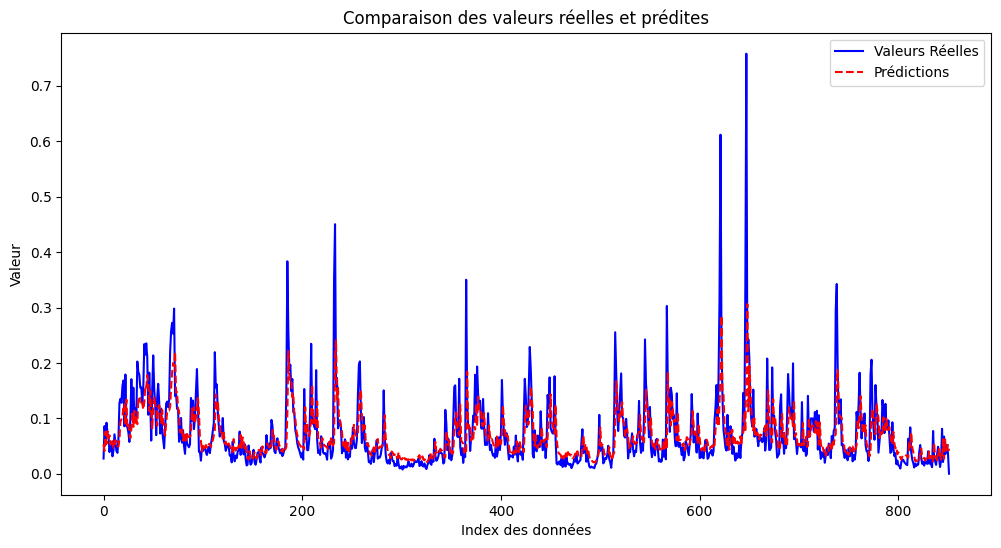

In [17]:
import matplotlib.pyplot as plt

# Réorganiser y_pred pour correspondre à la dernière valeur de chaque séquence
y_pred_per_sequence = y_pred.reshape(-1, 5)[:,-1]

# Vérifier que la réorganisation donne la bonne forme
print("y_pred_per_sequence shape:", y_pred_per_sequence.shape)

# Vérifier que les formes de y_test_seq et y_pred_per_sequence sont les mêmes
if y_test_seq.shape[0] == y_pred_per_sequence.shape[0]:
    y_test_actual = y_test_seq[:, -1]  # Prendre la dernière colonne si y_test_seq est 2D
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Valeurs Réelles', color='blue')
    plt.plot(y_pred_per_sequence, label='Prédictions', color='red', linestyle='--')
    
    plt.title('Comparaison des valeurs réelles et prédites')
    plt.xlabel('Index des données')
    plt.ylabel('Valeur')
    plt.legend()
    plt.show()
else:
    print("Les formes après réorganisation ne correspondent toujours pas.")


> 

> Graphique des Résidus

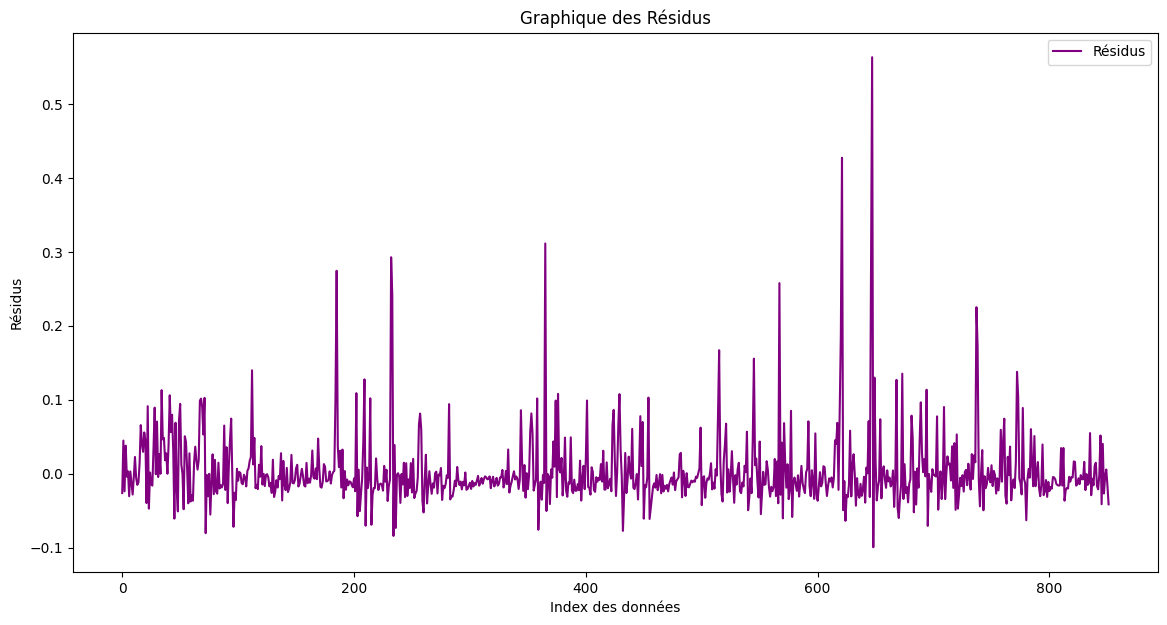

In [18]:
y_test_actual = y_test_seq[:, -1]
y_pred_per_sequence = y_pred.reshape(-1, 5)[:, -1]

# Calcul des résidus
residuals = y_test_actual - y_pred_per_sequence

# Graphique des résidus
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Résidus', color='purple')
plt.title('Graphique des Résidus')
plt.xlabel('Index des données')
plt.ylabel('Résidus')
plt.legend()
plt.show()


> Histogramme des Erreurs

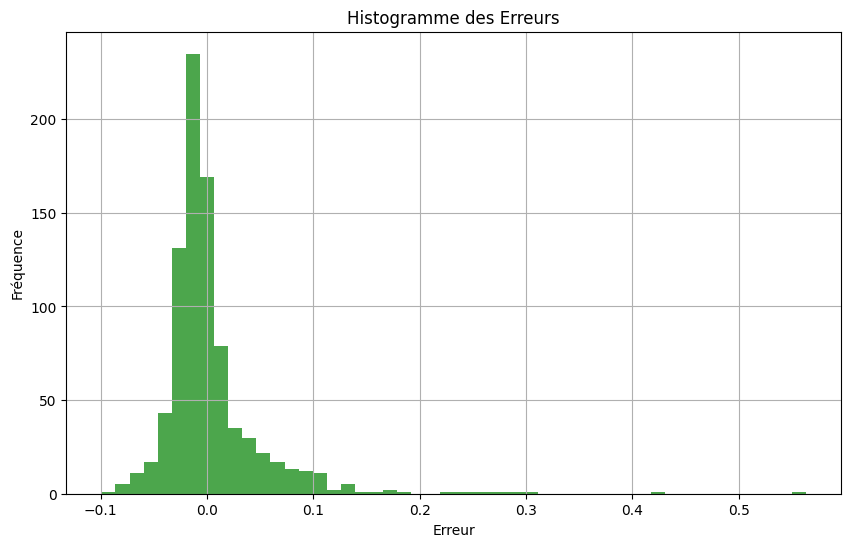

In [19]:
# Calcul des résidus
residuals = y_test_actual - y_pred_per_sequence
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='green', alpha=0.7)
plt.title('Histogramme des Erreurs')
plt.xlabel('Erreur')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()
